In [21]:
#load model
#load data
# create new dataset which has more information (country, number of genes etc)
# run a 1 epoch no batching training
# extract the CLS 
#PCA --> Plotting 

import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchtext
import torchtext.vocab as vocab
from pathlib import Path
import os
import re
from copy import deepcopy


from data_preprocessing import data_loader, data_original
from build_vocabulary import vocab_geno
from build_vocabulary import vocab_pheno
from bert_builder import BERT
from misc import get_paths
from misc import model_loader

############################
model_name = '2024-04-09modelEnc3Emb512Mask0.5ModeTrueEncoderExperiment.pt'
load_directory = "D://Models//0904EncExperiment//"

load_state = load_directory + model_name
hyperparameters = re.findall('[A-Z][^A-Z]*', model_name)
numbers = []
for i in range (len(hyperparameters)):
    numbers.append(re.findall('\d+', hyperparameters[i]))

parameters = [int(num) for sublist in numbers for num in sublist if num]


num_enc = parameters[0]
dim_emb = parameters[1]
dim_hidden = parameters[1]
mask_prob = 0

########################
threshold_year = 1970
max_length = [51,44]
mask_prob = 0.15
drop_prob = 0.2
reduced_samples = 1000 

attention_heads = 4 

include_pheno = True   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#############################

base_dir = Path(os.path.abspath(''))
os.chdir(base_dir)
data_dir, ab_dir, save_directory = get_paths()

print(f"\n Retrieving data from: {data_dir}")
print("Loading data...")
NCBI,ab_df = data_loader(include_pheno,threshold_year,data_dir,ab_dir)
NCBI_geno_only = data_original(threshold_year,data_dir, ab_dir)
print(f"Data correctly loaded, {len(NCBI)} samples found")
print("Creating vocabulary...")
vocabulary_geno = vocab_geno(NCBI_geno_only)
vocabulary_pheno = vocab_pheno(ab_df)

class CLSDataset(Dataset):

    MASKED_INDICES_COLUMN = 'masked_indices'
    TOKEN_MASK_COLUMN = 'token_mask'
    NUM_GENES = 'num_genes'
    NUM_ABS = 'num_abs'
    LOCATIONS = 'locations'
    YEARS = 'years'
    ABCLASSES = 'num_abClasses'

    def __init__(self,
                 data: pd.DataFrame,
                 vocab_geno: vocab,
                 vocab_pheno: vocab,
                 max_seq_len: list,
                 mask_prob: float,
                 dim_emb: int,
                 include_pheno:bool,
                 random_state: int = 23,
                 ):
        
        self.random_state = random_state
        np.random.seed(self.random_state)

        CLS = '[CLS]'
        PAD = '[PAD]'
        MASK = '[MASK]'
        UNK = '[UNK]'

        self.include_pheno = include_pheno
        self.data = data.reset_index(drop=True) 
        self.num_samples = self.data.shape[0]
        self.vocab_geno = vocab_geno
        self.vocab_pheno = vocab_pheno
        self.dim_emb = dim_emb  
        self.vocab_size_geno = len(self.vocab_geno)
        self.CLS = CLS 
        self.PAD = PAD
        self.MASK = MASK
        self.UNK = UNK
        self.max_seq_len = max_seq_len
        self.mask_prob = mask_prob

        self.columns = [self.MASKED_INDICES_COLUMN, self.TOKEN_MASK_COLUMN, self.NUM_GENES, self.NUM_ABS, self.LOCATIONS,self.YEARS ,self.ABCLASSES]


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        input = torch.tensor(item[self.MASKED_INDICES_COLUMN],device=device).long()
        attention_mask = (input == self.vocab_geno[self.PAD]).unsqueeze(0)
        num_genes = torch.tensor(item[self.NUM_GENES], device=device).long()
        num_abs = torch.tensor(item[self.NUM_ABS], device=device).long()
        locations = torch.tensor(item[self.LOCATIONS], device=device).long()
        years = torch.tensor(item[self.YEARS], device=device).long()
        AbClasses = torch.tensor(item[self.ABCLASSES], device=device).long()

        return input, attention_mask, num_genes, num_abs, locations, years, AbClasses


    def _construct_masking(self):
        sequences = deepcopy(self.data['genes'].tolist())
        masked_sequences = []
        target_indices_list = []
        seq_starts = [[self.CLS, self.data['year'].iloc[i], self.data['location'].iloc[i]] for i in range(self.data.shape[0])]

        for i, geno_seq in enumerate(sequences):
            seq_len = len(geno_seq)
            masking_index = np.random.rand(seq_len) < self.mask_prob   
            target_indices = np.array([-1]*seq_len)
            indices = masking_index.nonzero()[0]
            target_indices[indices] = self.vocab_geno.lookup_indices([geno_seq[i] for i in indices])
            for i in indices:
                r = np.random.rand()
                if r < 0.8:
                    geno_seq[i] = self.MASK
                elif r > 0.9:
                    geno_seq[i] = self.vocab_geno.lookup_token(np.random.randint(self.vocab_size_geno))
            geno_seq = seq_starts[i] + geno_seq
            target_indices = [-1]*3 + target_indices.tolist() 
            masked_sequences.append(geno_seq)
            target_indices_list.append(target_indices)
        masked_sequences = [seq + [self.PAD]*(self.max_seq_len[0] - len(seq)) for seq in masked_sequences]
        for i in range(len(target_indices_list)):
            indices = target_indices_list[i]
            padding = [-1] * (self.max_seq_len[0] - len(indices))
            target_indices_list[i] = indices + padding
        return masked_sequences, target_indices_list 
    
    def _num_tested(self):
        ab_sequences = deepcopy(self.data['AST_phenotypes'].tolist())
        gene_sequences = deepcopy(self.data['genes'].tolist())
        num_genes = []
        num_abs = []
        for i in range(len(gene_sequences)):
            current_gene_seq = gene_sequences[i]
            current_ab_seq = ab_sequences[i]

            num_genes.append(len(current_gene_seq))
            num_abs.append(len(current_ab_seq))
        
        return num_genes, num_abs
    
    def _location(self):
        location = deepcopy(self.data['location'].tolist())
        locations = []
        for i in range(len(location)):
            current_location = location[i]

            locations.append(self.vocab_geno.lookup_indices([current_location]))
        
        return locations
    
    def _year(self):
        year = deepcopy(self.data['year'].tolist())
        years = []
        for i in range(len(year)):
            current_year = year[i]

            years.append(self.vocab_geno.lookup_indices([current_year]))
        
        return years
    
    def _numAbClasses(self):
        antibiotic_classes = {
            'amoxicillinclavulanicacid': 'Penicillins',
            'ampicillin': 'Penicillins',
            'aztreonam': 'Monobactams',
            'cefazolin': 'Cephalosporins',
            'cefepime': 'Cephalosporins',
            'cefotaxime': 'Cephalosporins',
            'cefoxitin': 'Cephalosporins',
            'cefpodoxime': 'Cephalosporins',
            'ceftazidime': 'Cephalosporins',
            'ceftriaxone': 'Cephalosporins',
            'chloramphenicol': 'Others',
            'ciprofloxacin': 'Quinolones',
            'ertapenem': 'Carbapenems',
            'gentamicin': 'Aminoglycosides',
            'imipenem': 'Carbapenems',
            'levofloxacin': 'Quinolones',
            'meropenem': 'Carbapenems',
            'streptomycin': 'Aminoglycosides',
            'sulfamethoxazole': 'Sulfonamides',
            'sulfisoxazole': 'Sulfonamides',
            'tetracycline': 'Tetracyclines',
            'tobramycin': 'Aminoglycosides',
            'trimethoprim': 'Sulfonamides',
            'trimethoprimsulfamethoxazole': 'Sulfonamides'
        }
        Abs = deepcopy(self.data['AST_phenotypes'].tolist())
        NumAB = []
        for i, seq in enumerate(Abs):
            classes = set()
            for antibiotic_list in seq:
                for antibiotic_name in antibiotic_list.split(', '):
                    antibiotic_name = antibiotic_name.split('=')[0]
                    if antibiotic_name in antibiotic_classes:
                        classes.add(antibiotic_classes[antibiotic_name])
            NumAB.append(len(classes))
        return NumAB
    
    def prepare_dataset(self):
        masked_sequences, target_indices = self._construct_masking()
        indices_masked = [self.vocab_geno.lookup_indices(masked_seq) for masked_seq in masked_sequences]
        num_genes, num_abs = self._num_tested()
        locations = self._location()  
        num_abClasses = self._numAbClasses()
        years = self._year()

        rows = zip(indices_masked, target_indices, num_genes,num_abs, locations, years, num_abClasses)
        self.df = pd.DataFrame(rows, columns=self.columns)

dataset = CLSDataset(NCBI, vocabulary_geno, vocabulary_pheno, max_length, mask_prob, dim_emb, include_pheno)
dataset.prepare_dataset()
print("Dataset correctly prepared.")

df = pd.DataFrame(columns=[f"col_{i}" for i in range(dim_emb)])
model = BERT(vocab_size=len(vocabulary_geno), dim_embedding = dim_emb, dim_hidden=dim_hidden, attention_heads=8, num_encoders=num_enc, dropout_prob=drop_prob, num_ab=len(vocabulary_pheno), cls_mode=True, device=device).to(device)

cls_mode = True
model = model_loader(load_state,vocabulary_geno, vocabulary_pheno, dim_emb, dim_hidden, num_enc, drop_prob, cls_mode, device)

for i in range(len(dataset)):
    cls_s = model(dataset[i][0], dataset[i][1]) 
    cls_s = cls_s.tolist()
    df.loc[i] = cls_s
num_genes = []
num_ab = []
locations = []
years = []
num_abClasses = []
for i in range(len(dataset)):
    num_genes.append(dataset[i][2].item())
    num_ab.append(dataset[i][3].item())
    locations.append(dataset[i][4].item())
    years.append(dataset[i][5].item())
    num_abClasses.append(dataset[i][6].item())
df['num_genes'] = num_genes
df['num_abs'] = num_ab
df['locations'] = locations
df['years'] = years
df['num_abClasses'] = num_abClasses


######################################



c:\Users\erika\Desktop\Exjobb\repo\base

 Retrieving data from: c:\Users\erika\Desktop\Exjobb\data
Loading data...
Data correctly loaded, 6486 samples found
Creating vocabulary...
Dataset correctly prepared.
Loading model from D://Models//0904EncExperiment//2024-04-09modelEnc3Emb512Mask0.5ModeTrueEncoderExperiment.pt


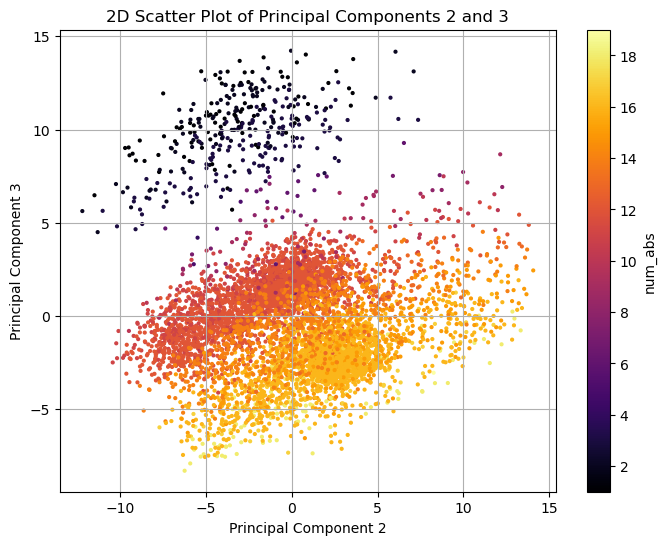

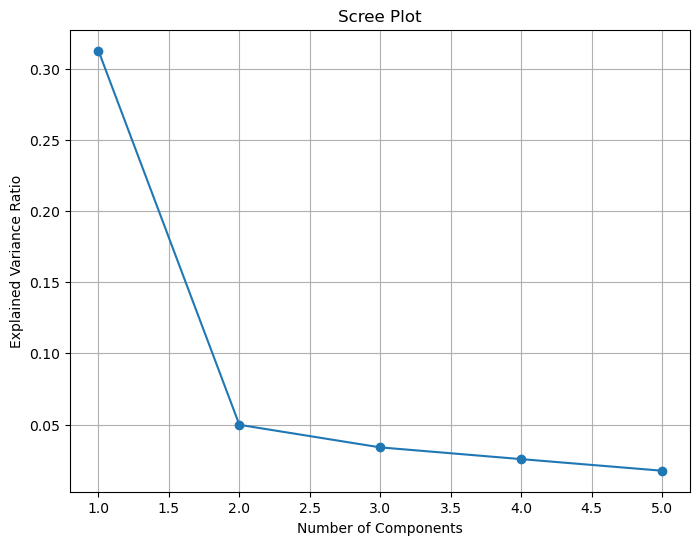

In [85]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

components = [2,3]

color = 'num_abs'

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df.iloc[:,:-3])
explained_variance_ratio = pca.explained_variance_ratio_

# Select the specified components
selected_components = [component - 1 for component in components]  # Convert to 0-based indexing
principalDf = pd.DataFrame(data=principalComponents[:, selected_components], 
                           columns=[f'principal component {c}' for c in components])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf[f'principal component {components[0]}'], 
                      principalDf[f'principal component {components[1]}'], 
                      c=df[color], cmap='inferno', s=4)  

plt.title(f'2D Scatter Plot of Principal Components {components[0]} and {components[1]}')
plt.xlabel(f'Principal Component {components[0]}')
plt.ylabel(f'Principal Component {components[1]}')
plt.grid(True)

# Add color bar
plt.colorbar(scatter, label=color)

plt.show()

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()



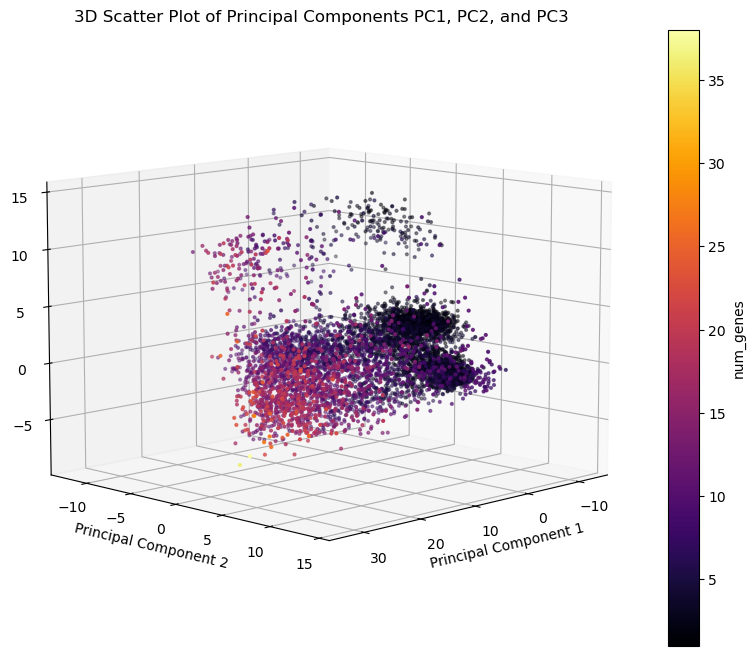

In [99]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Importing 3D plotting module
import pandas as pd

# Perform PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df.iloc[:,:-3])
color = 'num_genes'

# Select the specified components
selected_components = [0, 1, 2]  # PC1, PC2, PC3
principalDf = pd.DataFrame(data=principalComponents[:, selected_components], 
                           columns=[f'principal component {c}' for c in selected_components])

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(principalDf['principal component 0'], 
                     principalDf['principal component 1'], 
                     principalDf['principal component 2'], 
                     c=df[color], cmap='inferno', s=4)

# Title and labels
ax.set_title('3D Scatter Plot of Principal Components PC1, PC2, and PC3')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add color bar
plt.colorbar(scatter, label=color)

# Change the viewing angle
ax.view_init(elev=10, azim=45)  # Adjust the elevation and azimuth angles as needed

plt.show()

In [115]:
principalDf

,principal component 0,principal component 1,principal component 2
0,7.546888,2.129436,12.495436
1,16.318523,0.811923,14.019729
2,11.647328,-6.529292,10.043239
3,20.070144,5.648453,-2.870846
4,24.434320,6.208757,-4.442408
...,...,...,...
6481,10.197578,-4.062613,-4.355045
6482,13.031227,8.135087,2.610903
6483,19.579328,3.694980,-2.364975
6484,2.460308,2.696175,-0.062087


In [121]:
import pandas as pd

# Assuming df is your DataFrame
# Replace 'df' with the name of your DataFrame

# Get the row indexes of the 30 highest values in column 3
top_30_indexes = principalDf.nlargest(30, principalDf.columns[2]).index

# Get the row indexes of the 30 lowest values in column 3
bottom_30_indexes = principalDf.nsmallest(30, principalDf.columns[2]).index

print("Top 30 indexes:", top_30_indexes)
print("Bottom 30 indexes:", bottom_30_indexes)
top_df = NCBI.iloc[top_30_indexes]
bot_df = NCBI.iloc[bottom_30_indexes]
top_genes = top_df['genes'].tolist()
bot_genes = bot_df['genes'].tolist()
top_ab = top_df['AST_phenotypes'].tolist()
bot_ab = bot_df['AST_phenotypes'].tolist()


Top 30 indexes: Index([3450,  487,    1,  478,  394,  434, 3424,  467,  387,  528, 3548,  433,
        498,  422,  473,  419,  436,  472,  397, 3432,  468,  501,  480, 3572,
       3423,  381,    0,  416,  490,  509],
      dtype='int64')
Bottom 30 indexes: Index([3332, 3235, 5319, 3361, 3363, 3327, 3230, 4655, 4615, 4196, 3352, 3331,
        441, 5369, 3379, 3236, 3353, 4237, 3840, 3805, 3906, 4640, 3320, 3232,
       3328, 3385, 3348, 3286, 3334, 3294],
      dtype='int64')


In [124]:
from collections import Counter

# Assuming your data is loaded as a list of lists named 'data'
# Replace 'data' with the name of your list of lists

# Flatten the list of lists
flattened_data = [gene for sublist in bot_genes for gene in sublist]

# Count the occurrences of each gene
gene_counts = Counter(flattened_data)

# Print the gene counts
for gene, count in gene_counts.items():
    print(f"{gene}: {count}")

aac(3)-VIa: 3
sul2: 26
aph(3')-Ia: 7
aadA1: 13
aadA5: 10
aph(3'')-Ib: 30
aph(6)-Id: 30
blaCTX-M-1: 4
dfrA17: 10
sul1: 18
glpT_E448K=POINT: 27
tet(B): 15
blaTEM-1: 21
tet(M): 5
aadA2: 3
dfrA5: 2
marR_S3N=POINT: 3
dfrA1: 8
sat2: 2
pmrB_E123D=POINT: 7
catA1: 7
tet(A): 13
cyaA_S352T=POINT: 9
blaCMY-2: 11
qnrB19: 2
dfrA7: 3
mph(A): 8
dfrA12: 2
uhpT_E350Q=POINT: 2
parE_S458A=POINT: 1
blaCTX-M-14: 1
parC_S80I=POINT: 3
aac(3)-IIe: 1
cmlA1: 1
gyrA_D87N=POINT: 3
gyrA_S83L=POINT: 3
aac(6')-Ib3: 1
mcr-1.1: 1
floR: 1
fosA3: 1
blaCTX-M-55: 1
parC_A56T=POINT: 1
blaCTX-M: 1
rmtB1: 1
parE_L416F=POINT: 1
aac(3)-IId: 1
parE_D475E=POINT: 1
dfrA14: 1
pmrB_Y358N=POINT: 3
sul3: 1
mph(B): 1


In [126]:
from collections import Counter

# Assuming your data is loaded as a list of lists named 'data'
# Replace 'data' with the name of your list of lists

# Flatten the list of lists
flattened_data = [ab for sublist in bot_ab for ab in sublist]

# Count the occurrences of each gene
ab_counts = Counter(flattened_data)

# Print the gene counts
for ab, count in ab_counts.items():
    print(f"{ab}: {count}")

tetracycline=R: 27
sulfisoxazole=R: 16
ceftazidime=R: 15
meropenem=S: 29
amoxicillinclavulanicacid=S: 17
ciprofloxacin=S: 26
ceftriaxone=R: 15
trimethoprimsulfamethoxazole=R: 23
cefoxitin=S: 9
gentamicin=R: 6
cefpodoxime=R: 13
streptomycin=R: 17
imipenem=S: 29
chloramphenicol=S: 12
cefepime=S: 28
cefotaxime=R: 15
cefazolin=R: 15
ampicillin=R: 27
gentamicin=S: 24
trimethoprimsulfamethoxazole=S: 7
ceftazidime=S: 15
cefazolin=S: 14
cefpodoxime=S: 4
ceftriaxone=S: 15
cefotaxime=S: 5
aztreonam=S: 11
ertapenem=S: 12
tobramycin=S: 10
levofloxacin=S: 10
cefoxitin=R: 11
amoxicillinclavulanicacid=R: 11
chloramphenicol=R: 5
ampicillin=S: 3
tetracycline=S: 3
aztreonam=R: 2
tobramycin=R: 3
meropenem=R: 1
cefepime=R: 2
ciprofloxacin=R: 4
imipenem=R: 1
ertapenem=R: 1
levofloxacin=R: 3
sulfisoxazole=S: 1
